In [1]:
from warnings import filterwarnings

filterwarnings("ignore")
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from crypto_momentum_portfolios.utility.data_loader import CryptoDataLoaderQIL
from crypto_momentum_portfolios.utility.types import (
    DataFrequency,
    Fields,
    RebalanceFrequency,
    Side,
    RankingMode,
    AllocationMethod,
    RankingMethod,
    AllocationMode,
    Benchmark,
)
from crypto_momentum_portfolios.portfolio_management.benchmarks import (
    BenchmarkDataFrameBuilder,
)
from crypto_momentum_portfolios.portfolio_management.backtester import (
    PortfolioBacktester,
)

dl = CryptoDataLoaderQIL()  # CryptoDataLoader()
dl.assets

Loading BokehJS ...

Fetching symbols...: 100%|██████████| 21/21 [00:00<00:00, 38.11it/s]


['BCH-USDT',
 'BNB-USDT',
 'XLM-USDT',
 'KDA-USDT',
 'LTC-USDT',
 'ADA-USDT',
 'SOL-USDT',
 'DASH-USDT',
 'ETH-USDT',
 'BTC-USDT',
 'AVAX-USDT',
 'ATOM-USDT',
 'XTZ-USDT',
 'VET-USDT',
 'MATIC-USDT',
 'EOS-USDT',
 'LINK-USDT',
 'DOGE-USDT',
 'XRP-USDT',
 'ETC-USDT',
 'TRX-USDT']

In [2]:
DURATION_DAYS = 172  # Days
DURATION_MONTHS = 1  # Months

universe = (
    dl.get_crypto(
        "all",
        data_frequency=DataFrequency.DAILY,
        fields=[
            Fields.PRICE,
            Fields.MARKET_CAP,
            Fields.MOMENTUM,
            Fields.EMA_MOMENTUM,
            Fields.TS_MOMENTUM,
            Fields.VOLATILITY_NEUTRALIZED_MOMENTUM,
            Fields.RETURNS,
            Fields.VOLATILITY,
            Fields.VOLUME,
        ],
        flatten_fields_with_crypto=False,
        momentum_lookback=DURATION_DAYS * DURATION_MONTHS,
        ts_momentum_lookback=DURATION_DAYS * DURATION_MONTHS,
        ema_momentum_lookback=DURATION_DAYS * DURATION_MONTHS,
        volatility_lookback=DURATION_DAYS * DURATION_MONTHS,
    )
    .dropna()
    .loc[:]  # "2021-10-28"
)


universe.head()

price                                                          \
           BCH-USDT BNB-USDT  XLM-USDT KDA-USDT LTC-USDT  ADA-USDT SOL-USDT   
Date                                                                          
2022-01-24   292.16  371.146  0.197960   5.3573  109.555  1.066259   91.909   
2022-01-25   291.31  385.183  0.196735   5.3242  107.773  1.041987   94.590   
2022-01-26   289.07  375.088  0.196478   5.7540  107.000  1.076631   92.112   
2022-01-27   289.71  389.940  0.193937   5.7052  106.888  1.042857   89.545   
2022-01-28   297.00  386.010  0.198570   5.7666  109.390  1.048483   91.362   

                                        ...        volume                \
           DASH-USDT ETH-USDT BTC-USDT  ...     ATOM-USDT      XTZ-USDT   
Date                                    ...                               
2022-01-24     90.46  2440.38  36675.4  ...  1.514545e+08  1.784203e+06   
2022-01-25     89.35  2459.00  36956.9  ...  1.176560e+08  1.323799e+06   
2022-01-26     93.07  2462.30  36811.8  ...  1.047401e+08  1.824273e+06   
2022-01-27     91.76  2424.72  37166.8  ...  7.670976e+07  1.536441e+06   
2022-01-28     95.54  2546.15  37715.6  ...  9.149288e+07  1.548930e+06   

                                                                    \
                VET-USDT    MATIC-USDT      EOS-USDT     LINK-USDT   
Date                                                                 
2022-01-24  1.272397e+07  6.246247e+07  6.897905e+06  3.834346e+07   
2022-01-25  9.740023e+06  3.800364e+07  2.734522e+06  2.267748e+07   
2022-01-26  1.740634e+07  7.023078e+07  4.550285e+06  2.909127e+07   
2022-01-27  1.003315e+07  5.049867e+07  3.557479e+06  1.912872e+07   
2022-01-28  9.436845e+06  4.201557e+07  3.366855e+06  1.695484e+07   

                                                                    
               DOGE-USDT      XRP-USDT      ETC-USDT      TRX-USDT  
Date                                                                
2022-01-24  1.402437e+07  5.233236e+07  1.905304e+06  1.005730e+07  
2022-01-25  2.217468e+07  3.468339e+07  1.054658e+06  8.606156e+06  
2022-01-26  2.065531e+07  4.937823e+07  9.080426e+05  9.153510e+06  
2022-01-27  1.019655e+07  3.303448e+07  6.789507e+05  6.611473e+06  
2022-01-28  5.249395e+06  2.897449e+07  9.419104e+05  8.139098e+06  

[5 rows x 189 columns]

# Building a benchmark


## Capitalization weighted index


In [3]:
benchmarks = (
    BenchmarkDataFrameBuilder(universe)
    .build_equally_weighted_benchmark(
        rebalance_frequency=RebalanceFrequency.MONTHLY, side=Side.LONG, verbose=False
    )
    .build_capitalization_weighted_benchmark(
        capitalization_field=Fields.MARKET_CAP,
        rebalance_frequency=RebalanceFrequency.MONTHLY,
        side=Side.LONG,
        verbose=False,
    )
    .build_bitcoin_benchmark()
    .collect_benchmark_returns()
)
benchmarks

Building the Benchmark...:  10%|█         | 73/717 [00:00<00:00, 724.22it/s]

,equal_weighted_benchmark,capi_weighted_benchmark,bitcoin_benchmark
Date,,,
2022-01-24,-0.057753,-0.036630,0.011635
2022-01-25,0.010596,0.009886,0.007675
2022-01-26,-0.002117,-0.010766,-0.003926
2022-01-27,-0.009186,-0.009157,0.009644
2022-01-28,0.023769,0.023160,0.014766
...,...,...,...
2024-01-06,-0.034578,-0.025481,-0.001415
2024-01-07,-0.004981,0.001147,0.002070
2024-01-08,0.032695,0.046440,0.065531


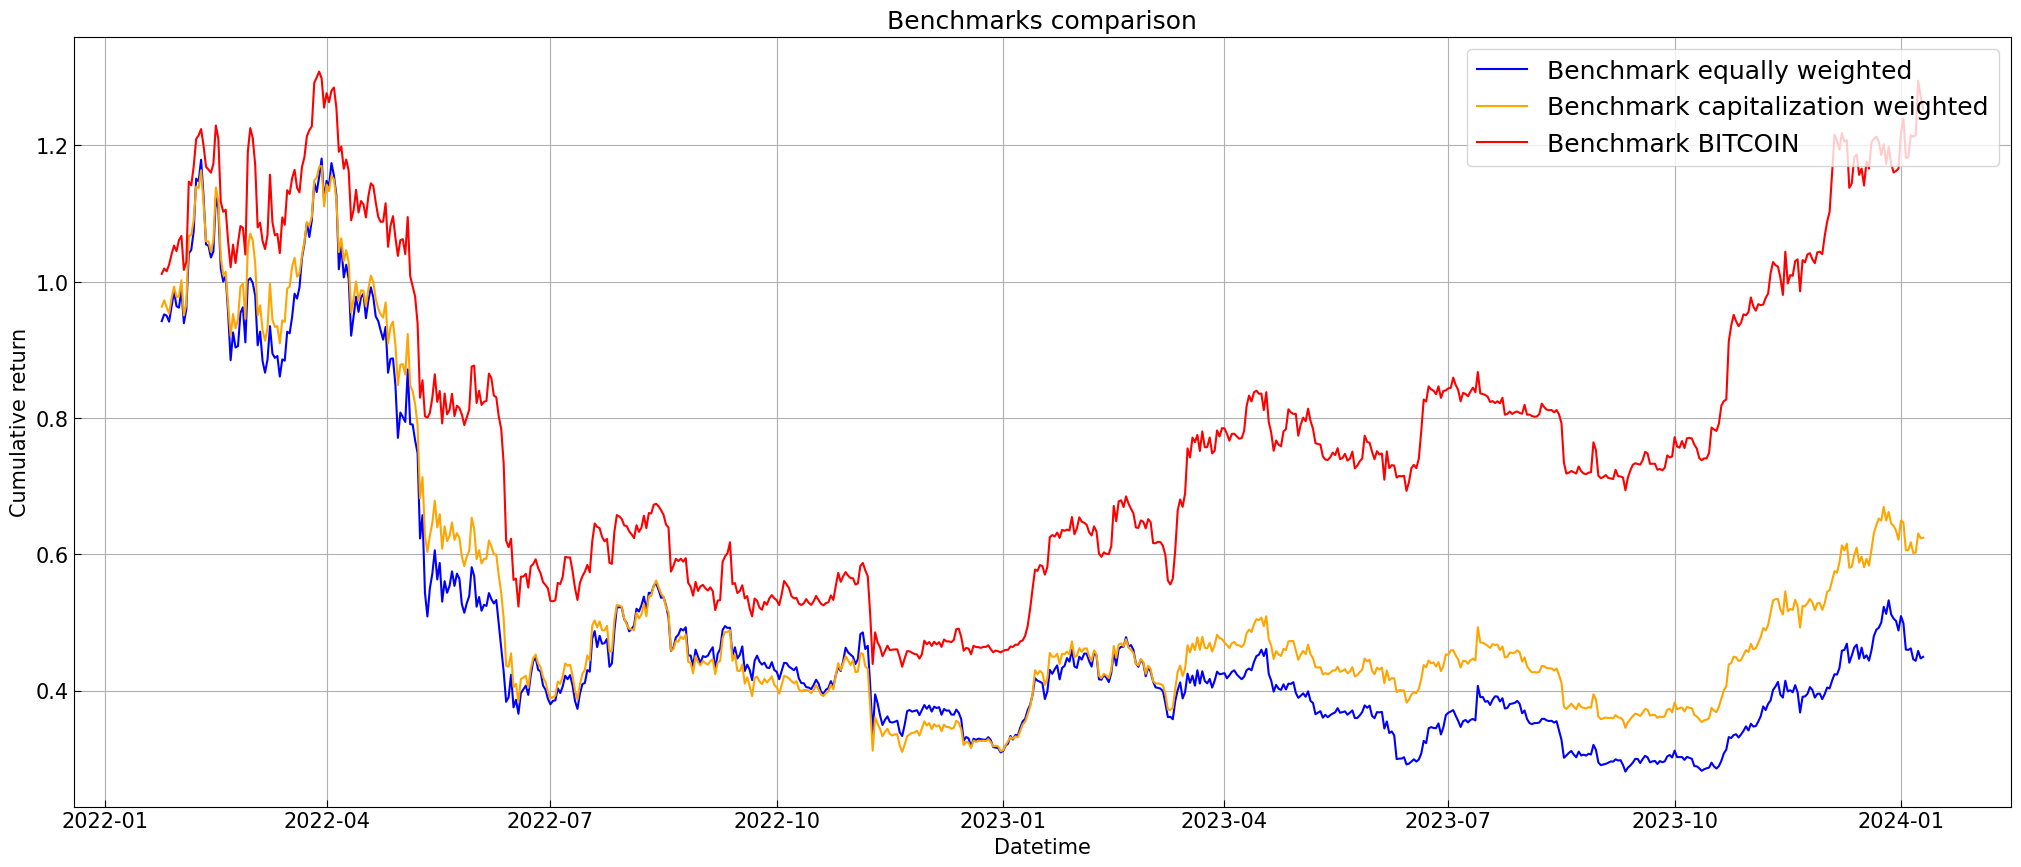

In [4]:
fsize = 15
tsize = 18
tdir = "in"
major = 5.0
minor = 3.0
lwidth = 0.8
lhandle = 2.0
plt.style.use("default")
# plt.rcParams['text.usetex'] = True
plt.rcParams["font.size"] = fsize
plt.rcParams["legend.fontsize"] = tsize
plt.rcParams["xtick.direction"] = tdir
plt.rcParams["ytick.direction"] = tdir
plt.rcParams["xtick.major.size"] = major
plt.rcParams["xtick.minor.size"] = minor
plt.rcParams["ytick.major.size"] = 5.0
plt.rcParams["ytick.minor.size"] = 3.0
plt.rcParams["axes.linewidth"] = lwidth
plt.rcParams["legend.handlelength"] = lhandle

f, ax = plt.subplots(1, 1, figsize=(25, 10))
ax.set_title("Benchmarks comparison", fontsize=18)
ax.grid()
ax.plot(
    (benchmarks["equal_weighted_benchmark"] + 1).cumprod(),
    label="Benchmark equally weighted",
    color="blue",
)
ax.plot(
    (benchmarks["capi_weighted_benchmark"] + 1).cumprod(),
    label="Benchmark capitalization weighted",
    color="orange",
)
ax.plot(
    (benchmarks["bitcoin_benchmark"] + 1).cumprod(),
    label="Benchmark BITCOIN",
    color="red",
)


ax.set_xlabel(
    "Datetime",
)
ax.set_ylabel(
    "Cumulative return",
)
ax.legend(
    loc="upper right",
)
# ax.set_yscale("log")

# Backtesting strategies

## Backtesting with a benchmark and a strategy


In [7]:
ptf_backtester = PortfolioBacktester(universe=universe, benchmarks=benchmarks)

returns, weights, stats_df = ptf_backtester.run_strategy(
    ranking_method=RankingMethod.TS_MOMENTUM,
    ranking_mode=RankingMode.DESCENDING,
    select_top_k_assets=5,
    allocation_method=AllocationMethod.MEAN_VARIANCE,
    allocation_mode=AllocationMode.CLASSIC,
    rebalance_frequency=RebalanceFrequency.MONTHLY,
    side=Side.LONG,
    benchmark=Benchmark.BITCOIN,
    verbose=False,
    print_stats=True,
    plot_curve=True,
    perform_t_stats=True,
)


-----------------Expected return------------------
Benchmark: 26.59% vs Strategy: 55.52%

t-stat: 4.08, p-value: 0.00
Statistically different from the bench

---------------Expected volatility----------------
Benchmark: 54.86% vs Strategy: 101.79%

t-stat: 21.39, p-value: 0.00
Statistically different from the bench

-----------------------VaR------------------------
Benchmark: -4.27% vs Strategy: -7.43%

t-stat: -22.05, p-value: 0.00
Statistically different from the bench

-----------------------CVaR-----------------------
Benchmark: -6.88% vs Strategy: -10.70%

t-stat: -18.97, p-value: 0.00
Statistically different from the bench

-------------------Sharpe ratio-------------------
Benchmark: 0.48 vs Strategy: 0.55

t-stat: 2.00, p-value: 0.05
Statistically different from the bench

--------------------Tail ratio--------------------
Benchmark: 1.03 vs Strategy: 1.25

t-stat: 6.58, p-value: 0.00
Statistically different from the bench

------------------Portfolio beta------------------
B

Loading BokehJS ...

Loading BokehJS ...

## Batch results computation

In [44]:
ptf_backtester = PortfolioBacktester(universe=universe, benchmarks=benchmarks)
stats_df_final = pd.DataFrame()
for k in [3, 5, 8, 10, 15]:
    _, _, stats_df = ptf_backtester.run_strategy(
        ranking_method=RankingMethod.VOLATILITY_NEUTRALIZED_MOMENTUM,
        ranking_mode=RankingMode.DESCENDING,
        select_top_k_assets=k,
        allocation_method=AllocationMethod.MEAN_VARIANCE,
        allocation_mode=AllocationMode.CLASSIC,
        rebalance_frequency=RebalanceFrequency.MONTHLY,
        side=Side.LONG,
        benchmark=Benchmark.CAPITALIZATION_WEIGHTED,
        verbose=False,
        print_stats=True,
        plot_curve=False,
        perform_t_stats=True,
    )
    stats_df["ALLOC_BENCH"] = f"CAPITALIZATION_WEIGHTED"
    stats_df["Assets"] = k
    stats_df_final = pd.concat([stats_df, stats_df_final])
    _, _, stats_df = ptf_backtester.run_strategy(
        ranking_method=RankingMethod.VOLATILITY_NEUTRALIZED_MOMENTUM,
        ranking_mode=RankingMode.DESCENDING,
        select_top_k_assets=k,
        allocation_method=AllocationMethod.MEAN_VARIANCE,
        allocation_mode=AllocationMode.CLASSIC,
        rebalance_frequency=RebalanceFrequency.MONTHLY,
        side=Side.LONG,
        benchmark=Benchmark.BITCOIN,
        verbose=False,
        print_stats=True,
        plot_curve=False,
        perform_t_stats=True,
    )
    stats_df["ALLOC_BENCH"] = f"BITCOIN"
    stats_df["Assets"] = k
    stats_df_final = pd.concat([stats_df, stats_df_final])
    _, _, stats_df = ptf_backtester.run_strategy(
        ranking_method=RankingMethod.VOLATILITY_NEUTRALIZED_MOMENTUM,
        ranking_mode=RankingMode.DESCENDING,
        select_top_k_assets=k,
        allocation_method=AllocationMethod.MEAN_VARIANCE,
        allocation_mode=AllocationMode.CLASSIC,
        rebalance_frequency=RebalanceFrequency.MONTHLY,
        side=Side.LONG,
        benchmark=Benchmark.EQUAL_WEIGHTED,
        verbose=False,
        print_stats=True,
        plot_curve=False,
        perform_t_stats=True,
    )
    stats_df["ALLOC_BENCH"] = f"EQUAL_WEIGHTED"
    stats_df["Assets"] = k
    stats_df_final = pd.concat([stats_df, stats_df_final])

stats_df_final.groupby(
    ["Assets", "ALLOC_BENCH", "metric"],
)[["value"]].agg(
    {"value": "first"}
).unstack(2).to_csv(f"../results/stats-VOLATILITY_NEUTRALIZED_MOMENTUM-MEAN_VARIANCE-MONTHLY_Rebalance.csv")

Backtesting the strategy...:  65%|██████▍   | 463/714 [00:00<00:00, 588.71it/s]


-----------------Expected return------------------
Benchmark: -6.15% vs Strategy: 16.06%

t-stat: 1.42, p-value: 0.16
Not statistically different from the bench

---------------Expected volatility----------------
Benchmark: 62.56% vs Strategy: 95.69%

t-stat: 12.32, p-value: 0.00
Statistically different from the bench

-----------------------VaR------------------------
Benchmark: -5.22% vs Strategy: -6.50%

t-stat: -8.62, p-value: 0.00
Statistically different from the bench

-----------------------CVaR-----------------------
Benchmark: -7.96% vs Strategy: -10.64%

t-stat: -9.31, p-value: 0.00
Statistically different from the bench

-------------------Sharpe ratio-------------------
Benchmark: -0.10 vs Strategy: 0.17

t-stat: 0.50, p-value: 0.62
Not statistically different from the bench

--------------------Tail ratio--------------------
Benchmark: 0.93 vs Strategy: 1.19

t-stat: 5.76, p-value: 0.00
Statistically different from the bench

------------------Portfolio beta--------------


-----------------Expected return------------------
Benchmark: 25.00% vs Strategy: 16.06%

t-stat: -2.09, p-value: 0.04
Statistically different from the bench

---------------Expected volatility----------------
Benchmark: 54.76% vs Strategy: 95.69%

t-stat: 16.56, p-value: 0.00
Statistically different from the bench

-----------------------VaR------------------------
Benchmark: -4.28% vs Strategy: -6.50%

t-stat: -17.65, p-value: 0.00
Statistically different from the bench

-----------------------CVaR-----------------------
Benchmark: -6.88% vs Strategy: -10.64%

t-stat: -19.05, p-value: 0.00
Statistically different from the bench

-------------------Sharpe ratio-------------------
Benchmark: 0.46 vs Strategy: 0.17

t-stat: -4.04, p-value: 0.00
Statistically different from the bench

--------------------Tail ratio--------------------
Benchmark: 1.02 vs Strategy: 1.19

t-stat: 1.74, p-value: 0.08
Not statistically different from the bench

------------------Portfolio beta---------------


-----------------Expected return------------------
Benchmark: -17.58% vs Strategy: 16.06%

t-stat: 2.09, p-value: 0.04
Statistically different from the bench

---------------Expected volatility----------------
Benchmark: 68.72% vs Strategy: 95.69%

t-stat: 10.70, p-value: 0.00
Statistically different from the bench

-----------------------VaR------------------------
Benchmark: -6.30% vs Strategy: -6.50%

t-stat: -1.71, p-value: 0.09
Not statistically different from the bench

-----------------------CVaR-----------------------
Benchmark: -9.03% vs Strategy: -10.64%

t-stat: -7.16, p-value: 0.00
Statistically different from the bench

-------------------Sharpe ratio-------------------
Benchmark: -0.26 vs Strategy: 0.17

t-stat: 1.75, p-value: 0.08
Not statistically different from the bench

--------------------Tail ratio--------------------
Benchmark: 0.85 vs Strategy: 1.19

t-stat: 7.25, p-value: 0.00
Statistically different from the bench

------------------Portfolio beta-------------


-----------------Expected return------------------
Benchmark: -6.15% vs Strategy: 27.55%

t-stat: 1.92, p-value: 0.06
Not statistically different from the bench

---------------Expected volatility----------------
Benchmark: 62.56% vs Strategy: 82.10%

t-stat: 16.04, p-value: 0.00
Statistically different from the bench

-----------------------VaR------------------------
Benchmark: -5.22% vs Strategy: -6.30%

t-stat: -7.90, p-value: 0.00
Statistically different from the bench

-----------------------CVaR-----------------------
Benchmark: -7.96% vs Strategy: -9.52%

t-stat: -8.24, p-value: 0.00
Statistically different from the bench

-------------------Sharpe ratio-------------------
Benchmark: -0.10 vs Strategy: 0.34

t-stat: 1.80, p-value: 0.07
Not statistically different from the bench

--------------------Tail ratio--------------------
Benchmark: 0.93 vs Strategy: 1.11

t-stat: 5.41, p-value: 0.00
Statistically different from the bench

------------------Portfolio beta---------------


-----------------Expected return------------------
Benchmark: 25.00% vs Strategy: 27.55%

t-stat: 1.06, p-value: 0.29
Not statistically different from the bench

---------------Expected volatility----------------
Benchmark: 54.76% vs Strategy: 82.10%

t-stat: 24.58, p-value: 0.00
Statistically different from the bench

-----------------------VaR------------------------
Benchmark: -4.28% vs Strategy: -6.30%

t-stat: -15.83, p-value: 0.00
Statistically different from the bench

-----------------------CVaR-----------------------
Benchmark: -6.88% vs Strategy: -9.52%

t-stat: -12.76, p-value: 0.00
Statistically different from the bench

-------------------Sharpe ratio-------------------
Benchmark: 0.46 vs Strategy: 0.34

t-stat: 0.14, p-value: 0.89
Not statistically different from the bench

--------------------Tail ratio--------------------
Benchmark: 1.02 vs Strategy: 1.11

t-stat: 3.40, p-value: 0.00
Statistically different from the bench

------------------Portfolio beta--------------


-----------------Expected return------------------
Benchmark: -17.58% vs Strategy: 27.55%

t-stat: 4.27, p-value: 0.00
Statistically different from the bench

---------------Expected volatility----------------
Benchmark: 68.72% vs Strategy: 82.10%

t-stat: 11.15, p-value: 0.00
Statistically different from the bench

-----------------------VaR------------------------
Benchmark: -6.30% vs Strategy: -6.30%

t-stat: 1.17, p-value: 0.25
Not statistically different from the bench

-----------------------CVaR-----------------------
Benchmark: -9.03% vs Strategy: -9.52%

t-stat: -1.00, p-value: 0.32
Not statistically different from the bench

-------------------Sharpe ratio-------------------
Benchmark: -0.26 vs Strategy: 0.34

t-stat: 4.37, p-value: 0.00
Statistically different from the bench

--------------------Tail ratio--------------------
Benchmark: 0.85 vs Strategy: 1.11

t-stat: 8.47, p-value: 0.00
Statistically different from the bench

------------------Portfolio beta---------------


-----------------Expected return------------------
Benchmark: -6.15% vs Strategy: 5.49%

t-stat: 1.09, p-value: 0.28
Not statistically different from the bench

---------------Expected volatility----------------
Benchmark: 62.56% vs Strategy: 76.70%

t-stat: 18.49, p-value: 0.00
Statistically different from the bench

-----------------------VaR------------------------
Benchmark: -5.22% vs Strategy: -6.09%

t-stat: -8.72, p-value: 0.00
Statistically different from the bench

-----------------------CVaR-----------------------
Benchmark: -7.96% vs Strategy: -8.93%

t-stat: -6.07, p-value: 0.00
Statistically different from the bench

-------------------Sharpe ratio-------------------
Benchmark: -0.10 vs Strategy: 0.07

t-stat: 1.01, p-value: 0.31
Not statistically different from the bench

--------------------Tail ratio--------------------
Benchmark: 0.93 vs Strategy: 1.08

t-stat: 6.38, p-value: 0.00
Statistically different from the bench

------------------Portfolio beta----------------


-----------------Expected return------------------
Benchmark: 25.00% vs Strategy: 5.49%

t-stat: -0.75, p-value: 0.45
Not statistically different from the bench

---------------Expected volatility----------------
Benchmark: 54.76% vs Strategy: 76.70%

t-stat: 21.47, p-value: 0.00
Statistically different from the bench

-----------------------VaR------------------------
Benchmark: -4.28% vs Strategy: -6.09%

t-stat: -16.25, p-value: 0.00
Statistically different from the bench

-----------------------CVaR-----------------------
Benchmark: -6.88% vs Strategy: -8.93%

t-stat: -10.33, p-value: 0.00
Statistically different from the bench

-------------------Sharpe ratio-------------------
Benchmark: 0.46 vs Strategy: 0.07

t-stat: -1.57, p-value: 0.12
Not statistically different from the bench

--------------------Tail ratio--------------------
Benchmark: 1.02 vs Strategy: 1.08

t-stat: 2.65, p-value: 0.01
Statistically different from the bench

------------------Portfolio beta-------------


-----------------Expected return------------------
Benchmark: -17.58% vs Strategy: 5.49%

t-stat: 1.42, p-value: 0.16
Not statistically different from the bench

---------------Expected volatility----------------
Benchmark: 68.72% vs Strategy: 76.70%

t-stat: 5.54, p-value: 0.00
Statistically different from the bench

-----------------------VaR------------------------
Benchmark: -6.30% vs Strategy: -6.09%

t-stat: 7.24, p-value: 0.00
Statistically different from the bench

-----------------------CVaR-----------------------
Benchmark: -9.03% vs Strategy: -8.93%

t-stat: 2.89, p-value: 0.00
Statistically different from the bench

-------------------Sharpe ratio-------------------
Benchmark: -0.26 vs Strategy: 0.07

t-stat: 1.46, p-value: 0.15
Not statistically different from the bench

--------------------Tail ratio--------------------
Benchmark: 0.85 vs Strategy: 1.08

t-stat: 8.35, p-value: 0.00
Statistically different from the bench

------------------Portfolio beta------------------


-----------------Expected return------------------
Benchmark: -6.15% vs Strategy: -5.67%

t-stat: -0.35, p-value: 0.73
Not statistically different from the bench

---------------Expected volatility----------------
Benchmark: 62.56% vs Strategy: 77.55%

t-stat: 15.00, p-value: 0.00
Statistically different from the bench

-----------------------VaR------------------------
Benchmark: -5.22% vs Strategy: -6.32%

t-stat: -8.60, p-value: 0.00
Statistically different from the bench

-----------------------CVaR-----------------------
Benchmark: -7.96% vs Strategy: -9.17%

t-stat: -6.33, p-value: 0.00
Statistically different from the bench

-------------------Sharpe ratio-------------------
Benchmark: -0.10 vs Strategy: -0.07

t-stat: -0.26, p-value: 0.80
Not statistically different from the bench

--------------------Tail ratio--------------------
Benchmark: 0.93 vs Strategy: 1.06

t-stat: 4.55, p-value: 0.00
Statistically different from the bench

------------------Portfolio beta------------


-----------------Expected return------------------
Benchmark: 25.00% vs Strategy: -5.67%

t-stat: -1.82, p-value: 0.07
Not statistically different from the bench

---------------Expected volatility----------------
Benchmark: 54.76% vs Strategy: 77.55%

t-stat: 21.48, p-value: 0.00
Statistically different from the bench

-----------------------VaR------------------------
Benchmark: -4.28% vs Strategy: -6.32%

t-stat: -17.36, p-value: 0.00
Statistically different from the bench

-----------------------CVaR-----------------------
Benchmark: -6.88% vs Strategy: -9.17%

t-stat: -11.22, p-value: 0.00
Statistically different from the bench

-------------------Sharpe ratio-------------------
Benchmark: 0.46 vs Strategy: -0.07

t-stat: -2.75, p-value: 0.01
Statistically different from the bench

--------------------Tail ratio--------------------
Benchmark: 1.02 vs Strategy: 1.06

t-stat: 2.36, p-value: 0.02
Statistically different from the bench

------------------Portfolio beta---------------


-----------------Expected return------------------
Benchmark: -17.58% vs Strategy: -5.67%

t-stat: 1.28, p-value: 0.20
Not statistically different from the bench

---------------Expected volatility----------------
Benchmark: 68.72% vs Strategy: 77.55%

t-stat: 9.37, p-value: 0.00
Statistically different from the bench

-----------------------VaR------------------------
Benchmark: -6.30% vs Strategy: -6.32%

t-stat: 0.80, p-value: 0.43
Not statistically different from the bench

-----------------------CVaR-----------------------
Benchmark: -9.03% vs Strategy: -9.17%

t-stat: 1.11, p-value: 0.27
Not statistically different from the bench

-------------------Sharpe ratio-------------------
Benchmark: -0.26 vs Strategy: -0.07

t-stat: 1.17, p-value: 0.24
Not statistically different from the bench

--------------------Tail ratio--------------------
Benchmark: 0.85 vs Strategy: 1.06

t-stat: 7.95, p-value: 0.00
Statistically different from the bench

------------------Portfolio beta--------


-----------------Expected return------------------
Benchmark: -6.15% vs Strategy: 18.66%

t-stat: 1.68, p-value: 0.10
Not statistically different from the bench

---------------Expected volatility----------------
Benchmark: 62.56% vs Strategy: 82.68%

t-stat: 20.20, p-value: 0.00
Statistically different from the bench

-----------------------VaR------------------------
Benchmark: -5.22% vs Strategy: -6.76%

t-stat: -10.62, p-value: 0.00
Statistically different from the bench

-----------------------CVaR-----------------------
Benchmark: -7.96% vs Strategy: -9.53%

t-stat: -7.07, p-value: 0.00
Statistically different from the bench

-------------------Sharpe ratio-------------------
Benchmark: -0.10 vs Strategy: 0.23

t-stat: 1.56, p-value: 0.12
Not statistically different from the bench

--------------------Tail ratio--------------------
Benchmark: 0.93 vs Strategy: 1.13

t-stat: 8.30, p-value: 0.00
Statistically different from the bench

------------------Portfolio beta--------------


-----------------Expected return------------------
Benchmark: 25.00% vs Strategy: 18.66%

t-stat: -2.69, p-value: 0.01
Statistically different from the bench

---------------Expected volatility----------------
Benchmark: 54.76% vs Strategy: 82.68%

t-stat: 31.29, p-value: 0.00
Statistically different from the bench

-----------------------VaR------------------------
Benchmark: -4.28% vs Strategy: -6.76%

t-stat: -22.02, p-value: 0.00
Statistically different from the bench

-----------------------CVaR-----------------------
Benchmark: -6.88% vs Strategy: -9.53%

t-stat: -14.33, p-value: 0.00
Statistically different from the bench

-------------------Sharpe ratio-------------------
Benchmark: 0.46 vs Strategy: 0.23

t-stat: -3.94, p-value: 0.00
Statistically different from the bench

--------------------Tail ratio--------------------
Benchmark: 1.02 vs Strategy: 1.13

t-stat: 3.98, p-value: 0.00
Statistically different from the bench

------------------Portfolio beta------------------
B


-----------------Expected return------------------
Benchmark: -17.58% vs Strategy: 18.66%

t-stat: 1.94, p-value: 0.06
Not statistically different from the bench

---------------Expected volatility----------------
Benchmark: 68.72% vs Strategy: 82.68%

t-stat: 16.01, p-value: 0.00
Statistically different from the bench

-----------------------VaR------------------------
Benchmark: -6.30% vs Strategy: -6.76%

t-stat: -2.22, p-value: 0.03
Statistically different from the bench

-----------------------CVaR-----------------------
Benchmark: -9.03% vs Strategy: -9.53%

t-stat: -3.46, p-value: 0.00
Statistically different from the bench

-------------------Sharpe ratio-------------------
Benchmark: -0.26 vs Strategy: 0.23

t-stat: 2.35, p-value: 0.02
Statistically different from the bench

--------------------Tail ratio--------------------
Benchmark: 0.85 vs Strategy: 1.13

t-stat: 10.29, p-value: 0.00
Statistically different from the bench

------------------Portfolio beta-----------------

In [45]:
ptf_backtester = PortfolioBacktester(universe=universe, benchmarks=benchmarks)
stats_df_final = pd.DataFrame()
for k in [3, 5, 8, 10, 15]:
    _, _, stats_df = ptf_backtester.run_strategy(
        ranking_method=RankingMethod.VOLATILITY_NEUTRALIZED_MOMENTUM,
        ranking_mode=RankingMode.DESCENDING,
        select_top_k_assets=k,
        allocation_method=AllocationMethod.RISK_PARITY,
        allocation_mode=AllocationMode.CLASSIC,
        rebalance_frequency=RebalanceFrequency.MONTHLY,
        side=Side.LONG,
        benchmark=Benchmark.CAPITALIZATION_WEIGHTED,
        verbose=False,
        print_stats=True,
        plot_curve=False,
        perform_t_stats=True,
    )
    stats_df["ALLOC_BENCH"] = f"CAPITALIZATION_WEIGHTED"
    stats_df["Assets"] = k
    stats_df_final = pd.concat([stats_df, stats_df_final])
    _, _, stats_df = ptf_backtester.run_strategy(
        ranking_method=RankingMethod.VOLATILITY_NEUTRALIZED_MOMENTUM,
        ranking_mode=RankingMode.DESCENDING,
        select_top_k_assets=k,
        allocation_method=AllocationMethod.RISK_PARITY,
        allocation_mode=AllocationMode.CLASSIC,
        rebalance_frequency=RebalanceFrequency.MONTHLY,
        side=Side.LONG,
        benchmark=Benchmark.BITCOIN,
        verbose=False,
        print_stats=True,
        plot_curve=False,
        perform_t_stats=True,
    )
    stats_df["ALLOC_BENCH"] = f"BITCOIN"
    stats_df["Assets"] = k
    stats_df_final = pd.concat([stats_df, stats_df_final])
    _, _, stats_df = ptf_backtester.run_strategy(
        ranking_method=RankingMethod.VOLATILITY_NEUTRALIZED_MOMENTUM,
        ranking_mode=RankingMode.DESCENDING,
        select_top_k_assets=k,
        allocation_method=AllocationMethod.RISK_PARITY,
        allocation_mode=AllocationMode.CLASSIC,
        rebalance_frequency=RebalanceFrequency.MONTHLY,
        side=Side.LONG,
        benchmark=Benchmark.EQUAL_WEIGHTED,
        verbose=False,
        print_stats=True,
        plot_curve=False,
        perform_t_stats=True,
    )
    stats_df["ALLOC_BENCH"] = f"EQUAL_WEIGHTED"
    stats_df["Assets"] = k
    stats_df_final = pd.concat([stats_df, stats_df_final])

stats_df_final.groupby(
    ["Assets", "ALLOC_BENCH", "metric"],
)[["value"]].agg(
    {"value": "first"}
).unstack(2).to_csv(f"../results/stats-VOLATILITY_NEUTRALIZED_MOMENTUM-RISK_PARITY-MONTHLY_Rebalance.csv")


-----------------Expected return------------------
Benchmark: -6.15% vs Strategy: -20.54%

t-stat: -2.14, p-value: 0.03
Statistically different from the bench

---------------Expected volatility----------------
Benchmark: 62.56% vs Strategy: 68.59%

t-stat: 4.99, p-value: 0.00
Statistically different from the bench

-----------------------VaR------------------------
Benchmark: -5.22% vs Strategy: -6.11%

t-stat: -5.66, p-value: 0.00
Statistically different from the bench

-----------------------CVaR-----------------------
Benchmark: -7.96% vs Strategy: -8.53%

t-stat: -2.05, p-value: 0.04
Statistically different from the bench

-------------------Sharpe ratio-------------------
Benchmark: -0.10 vs Strategy: -0.30

t-stat: -2.35, p-value: 0.02
Statistically different from the bench

--------------------Tail ratio--------------------
Benchmark: 0.93 vs Strategy: 0.95

t-stat: 1.43, p-value: 0.16
Not statistically different from the bench

------------------Portfolio beta----------------


-----------------Expected return------------------
Benchmark: 25.00% vs Strategy: -20.54%

t-stat: -4.32, p-value: 0.00
Statistically different from the bench

---------------Expected volatility----------------
Benchmark: 54.76% vs Strategy: 68.59%

t-stat: 13.10, p-value: 0.00
Statistically different from the bench

-----------------------VaR------------------------
Benchmark: -4.28% vs Strategy: -6.11%

t-stat: -13.92, p-value: 0.00
Statistically different from the bench

-----------------------CVaR-----------------------
Benchmark: -6.88% vs Strategy: -8.53%

t-stat: -9.49, p-value: 0.00
Statistically different from the bench

-------------------Sharpe ratio-------------------
Benchmark: 0.46 vs Strategy: -0.30

t-stat: -5.00, p-value: 0.00
Statistically different from the bench

--------------------Tail ratio--------------------
Benchmark: 1.02 vs Strategy: 0.95

t-stat: -1.26, p-value: 0.21
Not statistically different from the bench

------------------Portfolio beta--------------


-----------------Expected return------------------
Benchmark: -17.58% vs Strategy: -20.54%

t-stat: -0.45, p-value: 0.65
Not statistically different from the bench

---------------Expected volatility----------------
Benchmark: 68.72% vs Strategy: 68.59%

t-stat: -1.54, p-value: 0.13
Not statistically different from the bench

-----------------------VaR------------------------
Benchmark: -6.30% vs Strategy: -6.11%

t-stat: 5.98, p-value: 0.00
Statistically different from the bench

-----------------------CVaR-----------------------
Benchmark: -9.03% vs Strategy: -8.53%

t-stat: 3.73, p-value: 0.00
Statistically different from the bench

-------------------Sharpe ratio-------------------
Benchmark: -0.26 vs Strategy: -0.30

t-stat: -0.53, p-value: 0.60
Not statistically different from the bench

--------------------Tail ratio--------------------
Benchmark: 0.85 vs Strategy: 0.95

t-stat: 3.77, p-value: 0.00
Statistically different from the bench

------------------Portfolio beta--------


-----------------Expected return------------------
Benchmark: -6.15% vs Strategy: -8.83%

t-stat: 0.32, p-value: 0.75
Not statistically different from the bench

---------------Expected volatility----------------
Benchmark: 62.56% vs Strategy: 72.28%

t-stat: 5.96, p-value: 0.00
Statistically different from the bench

-----------------------VaR------------------------
Benchmark: -5.22% vs Strategy: -6.05%

t-stat: -5.67, p-value: 0.00
Statistically different from the bench

-----------------------CVaR-----------------------
Benchmark: -7.96% vs Strategy: -8.60%

t-stat: -2.54, p-value: 0.01
Statistically different from the bench

-------------------Sharpe ratio-------------------
Benchmark: -0.10 vs Strategy: -0.12

t-stat: 0.09, p-value: 0.93
Not statistically different from the bench

--------------------Tail ratio--------------------
Benchmark: 0.93 vs Strategy: 0.99

t-stat: 1.83, p-value: 0.07
Not statistically different from the bench

------------------Portfolio beta-----------


-----------------Expected return------------------
Benchmark: 25.00% vs Strategy: -8.83%

t-stat: -2.49, p-value: 0.01
Statistically different from the bench

---------------Expected volatility----------------
Benchmark: 54.76% vs Strategy: 72.28%

t-stat: 12.50, p-value: 0.00
Statistically different from the bench

-----------------------VaR------------------------
Benchmark: -4.28% vs Strategy: -6.05%

t-stat: -18.43, p-value: 0.00
Statistically different from the bench

-----------------------CVaR-----------------------
Benchmark: -6.88% vs Strategy: -8.60%

t-stat: -9.59, p-value: 0.00
Statistically different from the bench

-------------------Sharpe ratio-------------------
Benchmark: 0.46 vs Strategy: -0.12

t-stat: -3.92, p-value: 0.00
Statistically different from the bench

--------------------Tail ratio--------------------
Benchmark: 1.02 vs Strategy: 0.99

t-stat: 0.77, p-value: 0.44
Not statistically different from the bench

------------------Portfolio beta----------------


-----------------Expected return------------------
Benchmark: -17.58% vs Strategy: -8.83%

t-stat: 1.83, p-value: 0.07
Not statistically different from the bench

---------------Expected volatility----------------
Benchmark: 68.72% vs Strategy: 72.28%

t-stat: 2.02, p-value: 0.05
Statistically different from the bench

-----------------------VaR------------------------
Benchmark: -6.30% vs Strategy: -6.05%

t-stat: 5.03, p-value: 0.00
Statistically different from the bench

-----------------------CVaR-----------------------
Benchmark: -9.03% vs Strategy: -8.60%

t-stat: 5.63, p-value: 0.00
Statistically different from the bench

-------------------Sharpe ratio-------------------
Benchmark: -0.26 vs Strategy: -0.12

t-stat: 1.39, p-value: 0.17
Not statistically different from the bench

--------------------Tail ratio--------------------
Benchmark: 0.85 vs Strategy: 0.99

t-stat: 5.28, p-value: 0.00
Statistically different from the bench

------------------Portfolio beta----------------


-----------------Expected return------------------
Benchmark: -6.15% vs Strategy: -25.45%

t-stat: -1.09, p-value: 0.28
Not statistically different from the bench

---------------Expected volatility----------------
Benchmark: 62.56% vs Strategy: 68.66%

t-stat: 6.05, p-value: 0.00
Statistically different from the bench

-----------------------VaR------------------------
Benchmark: -5.22% vs Strategy: -6.06%

t-stat: -5.30, p-value: 0.00
Statistically different from the bench

-----------------------CVaR-----------------------
Benchmark: -7.96% vs Strategy: -8.57%

t-stat: -2.24, p-value: 0.03
Statistically different from the bench

-------------------Sharpe ratio-------------------
Benchmark: -0.10 vs Strategy: -0.37

t-stat: -1.29, p-value: 0.20
Not statistically different from the bench

--------------------Tail ratio--------------------
Benchmark: 0.93 vs Strategy: 0.92

t-stat: 1.61, p-value: 0.11
Not statistically different from the bench

------------------Portfolio beta--------


-----------------Expected return------------------
Benchmark: 25.00% vs Strategy: -25.45%

t-stat: -3.86, p-value: 0.00
Statistically different from the bench

---------------Expected volatility----------------
Benchmark: 54.76% vs Strategy: 68.66%

t-stat: 13.13, p-value: 0.00
Statistically different from the bench

-----------------------VaR------------------------
Benchmark: -4.28% vs Strategy: -6.06%

t-stat: -13.49, p-value: 0.00
Statistically different from the bench

-----------------------CVaR-----------------------
Benchmark: -6.88% vs Strategy: -8.57%

t-stat: -9.49, p-value: 0.00
Statistically different from the bench

-------------------Sharpe ratio-------------------
Benchmark: 0.46 vs Strategy: -0.37

t-stat: -4.22, p-value: 0.00
Statistically different from the bench

--------------------Tail ratio--------------------
Benchmark: 1.02 vs Strategy: 0.92

t-stat: -3.36, p-value: 0.00
Statistically different from the bench

------------------Portfolio beta------------------


-----------------Expected return------------------
Benchmark: -17.58% vs Strategy: -25.45%

t-stat: -0.32, p-value: 0.75
Not statistically different from the bench

---------------Expected volatility----------------
Benchmark: 68.72% vs Strategy: 68.66%

t-stat: 0.87, p-value: 0.39
Not statistically different from the bench

-----------------------VaR------------------------
Benchmark: -6.30% vs Strategy: -6.06%

t-stat: 5.08, p-value: 0.00
Statistically different from the bench

-----------------------CVaR-----------------------
Benchmark: -9.03% vs Strategy: -8.57%

t-stat: 3.46, p-value: 0.00
Statistically different from the bench

-------------------Sharpe ratio-------------------
Benchmark: -0.26 vs Strategy: -0.37

t-stat: -0.60, p-value: 0.55
Not statistically different from the bench

--------------------Tail ratio--------------------
Benchmark: 0.85 vs Strategy: 0.92

t-stat: 4.82, p-value: 0.00
Statistically different from the bench

------------------Portfolio beta---------


-----------------Expected return------------------
Benchmark: -6.15% vs Strategy: -17.34%

t-stat: -1.48, p-value: 0.14
Not statistically different from the bench

---------------Expected volatility----------------
Benchmark: 62.56% vs Strategy: 69.31%

t-stat: 6.48, p-value: 0.00
Statistically different from the bench

-----------------------VaR------------------------
Benchmark: -5.22% vs Strategy: -6.06%

t-stat: -6.18, p-value: 0.00
Statistically different from the bench

-----------------------CVaR-----------------------
Benchmark: -7.96% vs Strategy: -8.73%

t-stat: -3.65, p-value: 0.00
Statistically different from the bench

-------------------Sharpe ratio-------------------
Benchmark: -0.10 vs Strategy: -0.25

t-stat: -1.46, p-value: 0.15
Not statistically different from the bench

--------------------Tail ratio--------------------
Benchmark: 0.93 vs Strategy: 0.93

t-stat: 0.39, p-value: 0.70
Not statistically different from the bench

------------------Portfolio beta--------


-----------------Expected return------------------
Benchmark: 25.00% vs Strategy: -17.34%

t-stat: -3.62, p-value: 0.00
Statistically different from the bench

---------------Expected volatility----------------
Benchmark: 54.76% vs Strategy: 69.31%

t-stat: 13.51, p-value: 0.00
Statistically different from the bench

-----------------------VaR------------------------
Benchmark: -4.28% vs Strategy: -6.06%

t-stat: -12.69, p-value: 0.00
Statistically different from the bench

-----------------------CVaR-----------------------
Benchmark: -6.88% vs Strategy: -8.73%

t-stat: -10.42, p-value: 0.00
Statistically different from the bench

-------------------Sharpe ratio-------------------
Benchmark: 0.46 vs Strategy: -0.25

t-stat: -4.34, p-value: 0.00
Statistically different from the bench

--------------------Tail ratio--------------------
Benchmark: 1.02 vs Strategy: 0.93

t-stat: -2.45, p-value: 0.02
Statistically different from the bench

------------------Portfolio beta-----------------


-----------------Expected return------------------
Benchmark: -17.58% vs Strategy: -17.34%

t-stat: -0.37, p-value: 0.71
Not statistically different from the bench

---------------Expected volatility----------------
Benchmark: 68.72% vs Strategy: 69.31%

t-stat: -0.46, p-value: 0.65
Not statistically different from the bench

-----------------------VaR------------------------
Benchmark: -6.30% vs Strategy: -6.06%

t-stat: 5.33, p-value: 0.00
Statistically different from the bench

-----------------------CVaR-----------------------
Benchmark: -9.03% vs Strategy: -8.73%

t-stat: 3.88, p-value: 0.00
Statistically different from the bench

-------------------Sharpe ratio-------------------
Benchmark: -0.26 vs Strategy: -0.25

t-stat: -0.49, p-value: 0.62
Not statistically different from the bench

--------------------Tail ratio--------------------
Benchmark: 0.85 vs Strategy: 0.93

t-stat: 4.07, p-value: 0.00
Statistically different from the bench

------------------Portfolio beta--------


-----------------Expected return------------------
Benchmark: -6.15% vs Strategy: -30.47%

t-stat: -1.16, p-value: 0.25
Not statistically different from the bench

---------------Expected volatility----------------
Benchmark: 62.56% vs Strategy: 70.32%

t-stat: 8.98, p-value: 0.00
Statistically different from the bench

-----------------------VaR------------------------
Benchmark: -5.22% vs Strategy: -6.52%

t-stat: -6.71, p-value: 0.00
Statistically different from the bench

-----------------------CVaR-----------------------
Benchmark: -7.96% vs Strategy: -9.17%

t-stat: -6.11, p-value: 0.00
Statistically different from the bench

-------------------Sharpe ratio-------------------
Benchmark: -0.10 vs Strategy: -0.43

t-stat: -1.12, p-value: 0.26
Not statistically different from the bench

--------------------Tail ratio--------------------
Benchmark: 0.93 vs Strategy: 0.86

t-stat: -1.23, p-value: 0.22
Not statistically different from the bench

------------------Portfolio beta-------


-----------------Expected return------------------
Benchmark: 25.00% vs Strategy: -30.47%

t-stat: -6.78, p-value: 0.00
Statistically different from the bench

---------------Expected volatility----------------
Benchmark: 54.76% vs Strategy: 70.32%

t-stat: 20.50, p-value: 0.00
Statistically different from the bench

-----------------------VaR------------------------
Benchmark: -4.28% vs Strategy: -6.52%

t-stat: -18.70, p-value: 0.00
Statistically different from the bench

-----------------------CVaR-----------------------
Benchmark: -6.88% vs Strategy: -9.17%

t-stat: -12.47, p-value: 0.00
Statistically different from the bench

-------------------Sharpe ratio-------------------
Benchmark: 0.46 vs Strategy: -0.43

t-stat: -7.11, p-value: 0.00
Statistically different from the bench

--------------------Tail ratio--------------------
Benchmark: 1.02 vs Strategy: 0.86

t-stat: -7.32, p-value: 0.00
Statistically different from the bench

------------------Portfolio beta-----------------


-----------------Expected return------------------
Benchmark: -17.58% vs Strategy: -30.47%

t-stat: 1.18, p-value: 0.24
Not statistically different from the bench

---------------Expected volatility----------------
Benchmark: 68.72% vs Strategy: 70.32%

t-stat: 1.69, p-value: 0.09
Not statistically different from the bench

-----------------------VaR------------------------
Benchmark: -6.30% vs Strategy: -6.52%

t-stat: 2.65, p-value: 0.01
Statistically different from the bench

-----------------------CVaR-----------------------
Benchmark: -9.03% vs Strategy: -9.17%

t-stat: 1.71, p-value: 0.09
Not statistically different from the bench

-------------------Sharpe ratio-------------------
Benchmark: -0.26 vs Strategy: -0.43

t-stat: 1.39, p-value: 0.17
Not statistically different from the bench

--------------------Tail ratio--------------------
Benchmark: 0.85 vs Strategy: 0.86

t-stat: 3.50, p-value: 0.00
Statistically different from the bench

------------------Portfolio beta-------

In [46]:
ptf_backtester = PortfolioBacktester(universe=universe, benchmarks=benchmarks)
stats_df_final = pd.DataFrame()
for k in [3, 5, 8, 10, 15]:
    _, _, stats_df = ptf_backtester.run_strategy(
        ranking_method=RankingMethod.VOLATILITY_NEUTRALIZED_MOMENTUM,
        ranking_mode=RankingMode.DESCENDING,
        select_top_k_assets=k,
        allocation_method=AllocationMethod.CAPITALIZATION_WEIGHTED,
        allocation_mode=AllocationMode.CLASSIC,
        rebalance_frequency=RebalanceFrequency.MONTHLY,
        side=Side.LONG,
        benchmark=Benchmark.CAPITALIZATION_WEIGHTED,
        verbose=False,
        print_stats=True,
        plot_curve=False,
        perform_t_stats=True,
    )
    stats_df["ALLOC_BENCH"] = f"CAPITALIZATION_WEIGHTED"
    stats_df["Assets"] = k
    stats_df_final = pd.concat([stats_df, stats_df_final])
    _, _, stats_df = ptf_backtester.run_strategy(
        ranking_method=RankingMethod.VOLATILITY_NEUTRALIZED_MOMENTUM,
        ranking_mode=RankingMode.DESCENDING,
        select_top_k_assets=k,
        allocation_method=AllocationMethod.CAPITALIZATION_WEIGHTED,
        allocation_mode=AllocationMode.CLASSIC,
        rebalance_frequency=RebalanceFrequency.MONTHLY,
        side=Side.LONG,
        benchmark=Benchmark.BITCOIN,
        verbose=False,
        print_stats=True,
        plot_curve=False,
        perform_t_stats=True,
    )
    stats_df["ALLOC_BENCH"] = f"BITCOIN"
    stats_df["Assets"] = k
    stats_df_final = pd.concat([stats_df, stats_df_final])
    _, _, stats_df = ptf_backtester.run_strategy(
        ranking_method=RankingMethod.VOLATILITY_NEUTRALIZED_MOMENTUM,
        ranking_mode=RankingMode.DESCENDING,
        select_top_k_assets=k,
        allocation_method=AllocationMethod.CAPITALIZATION_WEIGHTED,
        allocation_mode=AllocationMode.CLASSIC,
        rebalance_frequency=RebalanceFrequency.MONTHLY,
        side=Side.LONG,
        benchmark=Benchmark.EQUAL_WEIGHTED,
        verbose=False,
        print_stats=True,
        plot_curve=False,
        perform_t_stats=True,
    )
    stats_df["ALLOC_BENCH"] = f"EQUAL_WEIGHTED"
    stats_df["Assets"] = k
    stats_df_final = pd.concat([stats_df, stats_df_final])

stats_df_final.groupby(
    ["Assets", "ALLOC_BENCH", "metric"],
)[["value"]].agg(
    {"value": "first"}
).unstack(2).to_csv(
    f"../results/stats-VOLATILITY_NEUTRALIZED_MOMENTUM-CAPITALIZATION_WEIGHTED-MONTHLY_Rebalance.csv"
)


-----------------Expected return------------------
Benchmark: -6.15% vs Strategy: -28.81%

t-stat: -2.44, p-value: 0.02
Statistically different from the bench

---------------Expected volatility----------------
Benchmark: 62.56% vs Strategy: 76.01%

t-stat: 8.86, p-value: 0.00
Statistically different from the bench

-----------------------VaR------------------------
Benchmark: -5.22% vs Strategy: -6.28%

t-stat: -9.44, p-value: 0.00
Statistically different from the bench

-----------------------CVaR-----------------------
Benchmark: -7.96% vs Strategy: -8.88%

t-stat: -5.97, p-value: 0.00
Statistically different from the bench

-------------------Sharpe ratio-------------------
Benchmark: -0.10 vs Strategy: -0.38

t-stat: -3.10, p-value: 0.00
Statistically different from the bench

--------------------Tail ratio--------------------
Benchmark: 0.93 vs Strategy: 1.02

t-stat: 2.11, p-value: 0.04
Statistically different from the bench

------------------Portfolio beta------------------
B


-----------------Expected return------------------
Benchmark: 25.00% vs Strategy: -28.81%

t-stat: -4.64, p-value: 0.00
Statistically different from the bench

---------------Expected volatility----------------
Benchmark: 54.76% vs Strategy: 76.01%

t-stat: 14.49, p-value: 0.00
Statistically different from the bench

-----------------------VaR------------------------
Benchmark: -4.28% vs Strategy: -6.28%

t-stat: -16.65, p-value: 0.00
Statistically different from the bench

-----------------------CVaR-----------------------
Benchmark: -6.88% vs Strategy: -8.88%

t-stat: -12.80, p-value: 0.00
Statistically different from the bench

-------------------Sharpe ratio-------------------
Benchmark: 0.46 vs Strategy: -0.38

t-stat: -5.95, p-value: 0.00
Statistically different from the bench

--------------------Tail ratio--------------------
Benchmark: 1.02 vs Strategy: 1.02

t-stat: 1.62, p-value: 0.11
Not statistically different from the bench

------------------Portfolio beta--------------


-----------------Expected return------------------
Benchmark: -17.58% vs Strategy: -28.81%

t-stat: -1.27, p-value: 0.21
Not statistically different from the bench

---------------Expected volatility----------------
Benchmark: 68.72% vs Strategy: 76.01%

t-stat: 3.12, p-value: 0.00
Statistically different from the bench

-----------------------VaR------------------------
Benchmark: -6.30% vs Strategy: -6.28%

t-stat: 3.90, p-value: 0.00
Statistically different from the bench

-----------------------CVaR-----------------------
Benchmark: -9.03% vs Strategy: -8.88%

t-stat: 2.78, p-value: 0.01
Statistically different from the bench

-------------------Sharpe ratio-------------------
Benchmark: -0.26 vs Strategy: -0.38

t-stat: -1.49, p-value: 0.14
Not statistically different from the bench

--------------------Tail ratio--------------------
Benchmark: 0.85 vs Strategy: 1.02

t-stat: 4.42, p-value: 0.00
Statistically different from the bench

------------------Portfolio beta-------------


-----------------Expected return------------------
Benchmark: -6.15% vs Strategy: -9.94%

t-stat: -1.51, p-value: 0.13
Not statistically different from the bench

---------------Expected volatility----------------
Benchmark: 62.56% vs Strategy: 75.62%

t-stat: 9.11, p-value: 0.00
Statistically different from the bench

-----------------------VaR------------------------
Benchmark: -5.22% vs Strategy: -6.17%

t-stat: -10.19, p-value: 0.00
Statistically different from the bench

-----------------------CVaR-----------------------
Benchmark: -7.96% vs Strategy: -8.85%

t-stat: -6.52, p-value: 0.00
Statistically different from the bench

-------------------Sharpe ratio-------------------
Benchmark: -0.10 vs Strategy: -0.13

t-stat: -1.77, p-value: 0.08
Not statistically different from the bench

--------------------Tail ratio--------------------
Benchmark: 0.93 vs Strategy: 1.01

t-stat: 1.73, p-value: 0.09
Not statistically different from the bench

------------------Portfolio beta--------


-----------------Expected return------------------
Benchmark: 25.00% vs Strategy: -9.94%

t-stat: -1.80, p-value: 0.08
Not statistically different from the bench

---------------Expected volatility----------------
Benchmark: 54.76% vs Strategy: 75.62%

t-stat: 12.23, p-value: 0.00
Statistically different from the bench

-----------------------VaR------------------------
Benchmark: -4.28% vs Strategy: -6.17%

t-stat: -14.85, p-value: 0.00
Statistically different from the bench

-----------------------CVaR-----------------------
Benchmark: -6.88% vs Strategy: -8.85%

t-stat: -10.05, p-value: 0.00
Statistically different from the bench

-------------------Sharpe ratio-------------------
Benchmark: 0.46 vs Strategy: -0.13

t-stat: -3.36, p-value: 0.00
Statistically different from the bench

--------------------Tail ratio--------------------
Benchmark: 1.02 vs Strategy: 1.01

t-stat: 1.89, p-value: 0.06
Not statistically different from the bench

------------------Portfolio beta-----------


-----------------Expected return------------------
Benchmark: -17.58% vs Strategy: -9.94%

t-stat: 0.08, p-value: 0.93
Not statistically different from the bench

---------------Expected volatility----------------
Benchmark: 68.72% vs Strategy: 75.62%

t-stat: 4.67, p-value: 0.00
Statistically different from the bench

-----------------------VaR------------------------
Benchmark: -6.30% vs Strategy: -6.17%

t-stat: 2.07, p-value: 0.04
Statistically different from the bench

-----------------------CVaR-----------------------
Benchmark: -9.03% vs Strategy: -8.85%

t-stat: 1.42, p-value: 0.16
Not statistically different from the bench

-------------------Sharpe ratio-------------------
Benchmark: -0.26 vs Strategy: -0.13

t-stat: -0.34, p-value: 0.73
Not statistically different from the bench

--------------------Tail ratio--------------------
Benchmark: 0.85 vs Strategy: 1.01

t-stat: 4.95, p-value: 0.00
Statistically different from the bench

------------------Portfolio beta-----------


-----------------Expected return------------------
Benchmark: -6.15% vs Strategy: -23.56%

t-stat: -4.17, p-value: 0.00
Statistically different from the bench

---------------Expected volatility----------------
Benchmark: 62.56% vs Strategy: 64.90%

t-stat: 3.41, p-value: 0.00
Statistically different from the bench

-----------------------VaR------------------------
Benchmark: -5.22% vs Strategy: -5.50%

t-stat: -3.16, p-value: 0.00
Statistically different from the bench

-----------------------CVaR-----------------------
Benchmark: -7.96% vs Strategy: -8.05%

t-stat: -1.07, p-value: 0.29
Not statistically different from the bench

-------------------Sharpe ratio-------------------
Benchmark: -0.10 vs Strategy: -0.36

t-stat: -4.14, p-value: 0.00
Statistically different from the bench

--------------------Tail ratio--------------------
Benchmark: 0.93 vs Strategy: 0.97

t-stat: 1.27, p-value: 0.21
Not statistically different from the bench

------------------Portfolio beta------------


-----------------Expected return------------------
Benchmark: 25.00% vs Strategy: -23.56%

t-stat: -5.22, p-value: 0.00
Statistically different from the bench

---------------Expected volatility----------------
Benchmark: 54.76% vs Strategy: 64.90%

t-stat: 15.74, p-value: 0.00
Statistically different from the bench

-----------------------VaR------------------------
Benchmark: -4.28% vs Strategy: -5.50%

t-stat: -11.36, p-value: 0.00
Statistically different from the bench

-----------------------CVaR-----------------------
Benchmark: -6.88% vs Strategy: -8.05%

t-stat: -7.64, p-value: 0.00
Statistically different from the bench

-------------------Sharpe ratio-------------------
Benchmark: 0.46 vs Strategy: -0.36

t-stat: -5.69, p-value: 0.00
Statistically different from the bench

--------------------Tail ratio--------------------
Benchmark: 1.02 vs Strategy: 0.97

t-stat: 0.18, p-value: 0.86
Not statistically different from the bench

------------------Portfolio beta---------------


-----------------Expected return------------------
Benchmark: -17.58% vs Strategy: -23.56%

t-stat: -0.05, p-value: 0.96
Not statistically different from the bench

---------------Expected volatility----------------
Benchmark: 68.72% vs Strategy: 64.90%

t-stat: -7.17, p-value: 0.00
Statistically different from the bench

-----------------------VaR------------------------
Benchmark: -6.30% vs Strategy: -5.50%

t-stat: 11.49, p-value: 0.00
Statistically different from the bench

-----------------------CVaR-----------------------
Benchmark: -9.03% vs Strategy: -8.05%

t-stat: 9.21, p-value: 0.00
Statistically different from the bench

-------------------Sharpe ratio-------------------
Benchmark: -0.26 vs Strategy: -0.36

t-stat: -0.26, p-value: 0.80
Not statistically different from the bench

--------------------Tail ratio--------------------
Benchmark: 0.85 vs Strategy: 0.97

t-stat: 5.71, p-value: 0.00
Statistically different from the bench

------------------Portfolio beta-----------


-----------------Expected return------------------
Benchmark: -6.15% vs Strategy: -14.28%

t-stat: -0.94, p-value: 0.35
Not statistically different from the bench

---------------Expected volatility----------------
Benchmark: 62.56% vs Strategy: 64.78%

t-stat: 3.57, p-value: 0.00
Statistically different from the bench

-----------------------VaR------------------------
Benchmark: -5.22% vs Strategy: -5.74%

t-stat: -2.03, p-value: 0.05
Statistically different from the bench

-----------------------CVaR-----------------------
Benchmark: -7.96% vs Strategy: -8.12%

t-stat: -0.61, p-value: 0.54
Not statistically different from the bench

-------------------Sharpe ratio-------------------
Benchmark: -0.10 vs Strategy: -0.22

t-stat: -1.04, p-value: 0.30
Not statistically different from the bench

--------------------Tail ratio--------------------
Benchmark: 0.93 vs Strategy: 0.97

t-stat: 2.69, p-value: 0.01
Statistically different from the bench

------------------Portfolio beta--------


-----------------Expected return------------------
Benchmark: 25.00% vs Strategy: -14.28%

t-stat: -5.05, p-value: 0.00
Statistically different from the bench

---------------Expected volatility----------------
Benchmark: 54.76% vs Strategy: 64.78%

t-stat: 10.94, p-value: 0.00
Statistically different from the bench

-----------------------VaR------------------------
Benchmark: -4.28% vs Strategy: -5.74%

t-stat: -11.29, p-value: 0.00
Statistically different from the bench

-----------------------CVaR-----------------------
Benchmark: -6.88% vs Strategy: -8.12%

t-stat: -6.97, p-value: 0.00
Statistically different from the bench

-------------------Sharpe ratio-------------------
Benchmark: 0.46 vs Strategy: -0.22

t-stat: -5.45, p-value: 0.00
Statistically different from the bench

--------------------Tail ratio--------------------
Benchmark: 1.02 vs Strategy: 0.97

t-stat: -1.67, p-value: 0.10
Not statistically different from the bench

------------------Portfolio beta--------------


-----------------Expected return------------------
Benchmark: -17.58% vs Strategy: -14.28%

t-stat: 1.03, p-value: 0.31
Not statistically different from the bench

---------------Expected volatility----------------
Benchmark: 68.72% vs Strategy: 64.78%

t-stat: -4.59, p-value: 0.00
Statistically different from the bench

-----------------------VaR------------------------
Benchmark: -6.30% vs Strategy: -5.74%

t-stat: 10.83, p-value: 0.00
Statistically different from the bench

-----------------------CVaR-----------------------
Benchmark: -9.03% vs Strategy: -8.12%

t-stat: 7.85, p-value: 0.00
Statistically different from the bench

-------------------Sharpe ratio-------------------
Benchmark: -0.26 vs Strategy: -0.22

t-stat: 0.81, p-value: 0.42
Not statistically different from the bench

--------------------Tail ratio--------------------
Benchmark: 0.85 vs Strategy: 0.97

t-stat: 6.31, p-value: 0.00
Statistically different from the bench

------------------Portfolio beta-------------


-----------------Expected return------------------
Benchmark: -6.15% vs Strategy: -13.85%

t-stat: -1.04, p-value: 0.30
Not statistically different from the bench

---------------Expected volatility----------------
Benchmark: 62.56% vs Strategy: 64.14%

t-stat: 2.16, p-value: 0.03
Statistically different from the bench

-----------------------VaR------------------------
Benchmark: -5.22% vs Strategy: -5.33%

t-stat: -1.55, p-value: 0.13
Not statistically different from the bench

-----------------------CVaR-----------------------
Benchmark: -7.96% vs Strategy: -8.05%

t-stat: 0.58, p-value: 0.57
Not statistically different from the bench

-------------------Sharpe ratio-------------------
Benchmark: -0.10 vs Strategy: -0.22

t-stat: -0.91, p-value: 0.37
Not statistically different from the bench

--------------------Tail ratio--------------------
Benchmark: 0.93 vs Strategy: 0.96

t-stat: 2.77, p-value: 0.01
Statistically different from the bench

------------------Portfolio beta-----


-----------------Expected return------------------
Benchmark: 25.00% vs Strategy: -13.85%

t-stat: -4.43, p-value: 0.00
Statistically different from the bench

---------------Expected volatility----------------
Benchmark: 54.76% vs Strategy: 64.14%

t-stat: 13.66, p-value: 0.00
Statistically different from the bench

-----------------------VaR------------------------
Benchmark: -4.28% vs Strategy: -5.33%

t-stat: -12.09, p-value: 0.00
Statistically different from the bench

-----------------------CVaR-----------------------
Benchmark: -6.88% vs Strategy: -8.05%

t-stat: -6.77, p-value: 0.00
Statistically different from the bench

-------------------Sharpe ratio-------------------
Benchmark: 0.46 vs Strategy: -0.22

t-stat: -4.91, p-value: 0.00
Statistically different from the bench

--------------------Tail ratio--------------------
Benchmark: 1.02 vs Strategy: 0.96

t-stat: -1.53, p-value: 0.13
Not statistically different from the bench

------------------Portfolio beta--------------


-----------------Expected return------------------
Benchmark: -17.58% vs Strategy: -13.85%

t-stat: -0.33, p-value: 0.74
Not statistically different from the bench

---------------Expected volatility----------------
Benchmark: 68.72% vs Strategy: 64.14%

t-stat: -7.50, p-value: 0.00
Statistically different from the bench

-----------------------VaR------------------------
Benchmark: -6.30% vs Strategy: -5.33%

t-stat: 8.44, p-value: 0.00
Statistically different from the bench

-----------------------CVaR-----------------------
Benchmark: -9.03% vs Strategy: -8.05%

t-stat: 6.09, p-value: 0.00
Statistically different from the bench

-------------------Sharpe ratio-------------------
Benchmark: -0.26 vs Strategy: -0.22

t-stat: -0.31, p-value: 0.75
Not statistically different from the bench

--------------------Tail ratio--------------------
Benchmark: 0.85 vs Strategy: 0.96

t-stat: 3.96, p-value: 0.00
Statistically different from the bench

------------------Portfolio beta------------

In [47]:
ptf_backtester = PortfolioBacktester(universe=universe, benchmarks=benchmarks)
stats_df_final = pd.DataFrame()
for k in [3, 5, 8, 10, 15]:
    _, _, stats_df = ptf_backtester.run_strategy(
        ranking_method=RankingMethod.VOLATILITY_NEUTRALIZED_MOMENTUM,
        ranking_mode=RankingMode.DESCENDING,
        select_top_k_assets=k,
        allocation_method=AllocationMethod.EQUAL_WEIGHTED,
        allocation_mode=AllocationMode.CLASSIC,
        rebalance_frequency=RebalanceFrequency.MONTHLY,
        side=Side.LONG,
        benchmark=Benchmark.CAPITALIZATION_WEIGHTED,
        verbose=False,
        print_stats=True,
        plot_curve=False,
        perform_t_stats=True,
    )
    stats_df["ALLOC_BENCH"] = f"CAPITALIZATION_WEIGHTED"
    stats_df["Assets"] = k
    stats_df_final = pd.concat([stats_df, stats_df_final])
    _, _, stats_df = ptf_backtester.run_strategy(
        ranking_method=RankingMethod.VOLATILITY_NEUTRALIZED_MOMENTUM,
        ranking_mode=RankingMode.DESCENDING,
        select_top_k_assets=k,
        allocation_method=AllocationMethod.EQUAL_WEIGHTED,
        allocation_mode=AllocationMode.CLASSIC,
        rebalance_frequency=RebalanceFrequency.MONTHLY,
        side=Side.LONG,
        benchmark=Benchmark.BITCOIN,
        verbose=False,
        print_stats=True,
        plot_curve=False,
        perform_t_stats=True,
    )
    stats_df["ALLOC_BENCH"] = f"BITCOIN"
    stats_df["Assets"] = k
    stats_df_final = pd.concat([stats_df, stats_df_final])
    _, _, stats_df = ptf_backtester.run_strategy(
        ranking_method=RankingMethod.VOLATILITY_NEUTRALIZED_MOMENTUM,
        ranking_mode=RankingMode.DESCENDING,
        select_top_k_assets=k,
        allocation_method=AllocationMethod.EQUAL_WEIGHTED,
        allocation_mode=AllocationMode.CLASSIC,
        rebalance_frequency=RebalanceFrequency.MONTHLY,
        side=Side.LONG,
        benchmark=Benchmark.EQUAL_WEIGHTED,
        verbose=False,
        print_stats=True,
        plot_curve=False,
        perform_t_stats=True,
    )
    stats_df["ALLOC_BENCH"] = f"EQUAL_WEIGHTED"
    stats_df["Assets"] = k
    stats_df_final = pd.concat([stats_df, stats_df_final])

stats_df_final.groupby(
    ["Assets", "ALLOC_BENCH", "metric"],
)[["value"]].agg(
    {"value": "first"}
).unstack(2).to_csv(
    f"../results/stats-VOLATILITY_NEUTRALIZED_MOMENTUM-EQUAL_WEIGHTED-MONTHLY_Rebalance.csv"
)

Backtesting the strategy...:   0%|          | 0/714 [00:00<?, ?it/s]


-----------------Expected return------------------
Benchmark: -6.15% vs Strategy: -23.53%

t-stat: -1.50, p-value: 0.14
Not statistically different from the bench

---------------Expected volatility----------------
Benchmark: 62.56% vs Strategy: 71.48%

t-stat: 8.55, p-value: 0.00
Statistically different from the bench

-----------------------VaR------------------------
Benchmark: -5.22% vs Strategy: -6.50%

t-stat: -6.97, p-value: 0.00
Statistically different from the bench

-----------------------CVaR-----------------------
Benchmark: -7.96% vs Strategy: -8.88%

t-stat: -3.27, p-value: 0.00
Statistically different from the bench

-------------------Sharpe ratio-------------------
Benchmark: -0.10 vs Strategy: -0.33

t-stat: -1.44, p-value: 0.15
Not statistically different from the bench

--------------------Tail ratio--------------------
Benchmark: 0.93 vs Strategy: 0.94

t-stat: 2.38, p-value: 0.02
Statistically different from the bench

------------------Portfolio beta------------


-----------------Expected return------------------
Benchmark: 25.00% vs Strategy: -23.53%

t-stat: -3.05, p-value: 0.00
Statistically different from the bench

---------------Expected volatility----------------
Benchmark: 54.76% vs Strategy: 71.48%

t-stat: 16.19, p-value: 0.00
Statistically different from the bench

-----------------------VaR------------------------
Benchmark: -4.28% vs Strategy: -6.50%

t-stat: -14.53, p-value: 0.00
Statistically different from the bench

-----------------------CVaR-----------------------
Benchmark: -6.88% vs Strategy: -8.88%

t-stat: -10.97, p-value: 0.00
Statistically different from the bench

-------------------Sharpe ratio-------------------
Benchmark: 0.46 vs Strategy: -0.33

t-stat: -3.86, p-value: 0.00
Statistically different from the bench

--------------------Tail ratio--------------------
Benchmark: 1.02 vs Strategy: 0.94

t-stat: -0.63, p-value: 0.53
Not statistically different from the bench

------------------Portfolio beta-------------


-----------------Expected return------------------
Benchmark: -17.58% vs Strategy: -23.53%

t-stat: -1.70, p-value: 0.09
Not statistically different from the bench

---------------Expected volatility----------------
Benchmark: 68.72% vs Strategy: 71.48%

t-stat: 1.76, p-value: 0.08
Not statistically different from the bench

-----------------------VaR------------------------
Benchmark: -6.30% vs Strategy: -6.50%

t-stat: 1.14, p-value: 0.26
Not statistically different from the bench

-----------------------CVaR-----------------------
Benchmark: -9.03% vs Strategy: -8.88%

t-stat: 0.10, p-value: 0.92
Not statistically different from the bench

-------------------Sharpe ratio-------------------
Benchmark: -0.26 vs Strategy: -0.33

t-stat: -1.82, p-value: 0.07
Not statistically different from the bench

--------------------Tail ratio--------------------
Benchmark: 0.85 vs Strategy: 0.94

t-stat: 1.38, p-value: 0.17
Not statistically different from the bench

------------------Portfolio b


-----------------Expected return------------------
Benchmark: -6.15% vs Strategy: -13.66%

t-stat: -1.15, p-value: 0.25
Not statistically different from the bench

---------------Expected volatility----------------
Benchmark: 62.56% vs Strategy: 72.54%

t-stat: 10.64, p-value: 0.00
Statistically different from the bench

-----------------------VaR------------------------
Benchmark: -5.22% vs Strategy: -6.66%

t-stat: -11.96, p-value: 0.00
Statistically different from the bench

-----------------------CVaR-----------------------
Benchmark: -7.96% vs Strategy: -8.81%

t-stat: -5.84, p-value: 0.00
Statistically different from the bench

-------------------Sharpe ratio-------------------
Benchmark: -0.10 vs Strategy: -0.19

t-stat: -1.36, p-value: 0.18
Not statistically different from the bench

--------------------Tail ratio--------------------
Benchmark: 0.93 vs Strategy: 0.96

t-stat: 2.09, p-value: 0.04
Statistically different from the bench

------------------Portfolio beta----------


-----------------Expected return------------------
Benchmark: 25.00% vs Strategy: -13.66%

t-stat: -3.34, p-value: 0.00
Statistically different from the bench

---------------Expected volatility----------------
Benchmark: 54.76% vs Strategy: 72.54%

t-stat: 16.87, p-value: 0.00
Statistically different from the bench

-----------------------VaR------------------------
Benchmark: -4.28% vs Strategy: -6.66%

t-stat: -20.18, p-value: 0.00
Statistically different from the bench

-----------------------CVaR-----------------------
Benchmark: -6.88% vs Strategy: -8.81%

t-stat: -12.04, p-value: 0.00
Statistically different from the bench

-------------------Sharpe ratio-------------------
Benchmark: 0.46 vs Strategy: -0.19

t-stat: -4.02, p-value: 0.00
Statistically different from the bench

--------------------Tail ratio--------------------
Benchmark: 1.02 vs Strategy: 0.96

t-stat: -2.32, p-value: 0.02
Statistically different from the bench

------------------Portfolio beta-----------------


-----------------Expected return------------------
Benchmark: -17.58% vs Strategy: -13.66%

t-stat: 1.11, p-value: 0.27
Not statistically different from the bench

---------------Expected volatility----------------
Benchmark: 68.72% vs Strategy: 72.54%

t-stat: 3.13, p-value: 0.00
Statistically different from the bench

-----------------------VaR------------------------
Benchmark: -6.30% vs Strategy: -6.66%

t-stat: 0.75, p-value: 0.45
Not statistically different from the bench

-----------------------CVaR-----------------------
Benchmark: -9.03% vs Strategy: -8.81%

t-stat: 1.30, p-value: 0.20
Not statistically different from the bench

-------------------Sharpe ratio-------------------
Benchmark: -0.26 vs Strategy: -0.19

t-stat: 1.30, p-value: 0.20
Not statistically different from the bench

--------------------Tail ratio--------------------
Benchmark: 0.85 vs Strategy: 0.96

t-stat: 3.58, p-value: 0.00
Statistically different from the bench

------------------Portfolio beta-------


-----------------Expected return------------------
Benchmark: -6.15% vs Strategy: -29.87%

t-stat: -1.46, p-value: 0.15
Not statistically different from the bench

---------------Expected volatility----------------
Benchmark: 62.56% vs Strategy: 69.70%

t-stat: 6.30, p-value: 0.00
Statistically different from the bench

-----------------------VaR------------------------
Benchmark: -5.22% vs Strategy: -6.20%

t-stat: -6.77, p-value: 0.00
Statistically different from the bench

-----------------------CVaR-----------------------
Benchmark: -7.96% vs Strategy: -8.86%

t-stat: -3.27, p-value: 0.00
Statistically different from the bench

-------------------Sharpe ratio-------------------
Benchmark: -0.10 vs Strategy: -0.43

t-stat: -1.37, p-value: 0.17
Not statistically different from the bench

--------------------Tail ratio--------------------
Benchmark: 0.93 vs Strategy: 0.89

t-stat: -0.78, p-value: 0.44
Not statistically different from the bench

------------------Portfolio beta-------


-----------------Expected return------------------
Benchmark: 25.00% vs Strategy: -29.87%

t-stat: -3.02, p-value: 0.00
Statistically different from the bench

---------------Expected volatility----------------
Benchmark: 54.76% vs Strategy: 69.70%

t-stat: 17.10, p-value: 0.00
Statistically different from the bench

-----------------------VaR------------------------
Benchmark: -4.28% vs Strategy: -6.20%

t-stat: -15.15, p-value: 0.00
Statistically different from the bench

-----------------------CVaR-----------------------
Benchmark: -6.88% vs Strategy: -8.86%

t-stat: -11.12, p-value: 0.00
Statistically different from the bench

-------------------Sharpe ratio-------------------
Benchmark: 0.46 vs Strategy: -0.43

t-stat: -3.49, p-value: 0.00
Statistically different from the bench

--------------------Tail ratio--------------------
Benchmark: 1.02 vs Strategy: 0.89

t-stat: -2.74, p-value: 0.01
Statistically different from the bench

------------------Portfolio beta-----------------


-----------------Expected return------------------
Benchmark: -17.58% vs Strategy: -29.87%

t-stat: -2.25, p-value: 0.03
Statistically different from the bench

---------------Expected volatility----------------
Benchmark: 68.72% vs Strategy: 69.70%

t-stat: 1.27, p-value: 0.21
Not statistically different from the bench

-----------------------VaR------------------------
Benchmark: -6.30% vs Strategy: -6.20%

t-stat: 1.49, p-value: 0.14
Not statistically different from the bench

-----------------------CVaR-----------------------
Benchmark: -9.03% vs Strategy: -8.86%

t-stat: 0.81, p-value: 0.42
Not statistically different from the bench

-------------------Sharpe ratio-------------------
Benchmark: -0.26 vs Strategy: -0.43

t-stat: -2.27, p-value: 0.03
Statistically different from the bench

--------------------Tail ratio--------------------
Benchmark: 0.85 vs Strategy: 0.89

t-stat: 1.86, p-value: 0.07
Not statistically different from the bench

------------------Portfolio beta-----


-----------------Expected return------------------
Benchmark: -6.15% vs Strategy: -17.88%

t-stat: -1.33, p-value: 0.19
Not statistically different from the bench

---------------Expected volatility----------------
Benchmark: 62.56% vs Strategy: 70.57%

t-stat: 9.04, p-value: 0.00
Statistically different from the bench

-----------------------VaR------------------------
Benchmark: -5.22% vs Strategy: -6.15%

t-stat: -7.26, p-value: 0.00
Statistically different from the bench

-----------------------CVaR-----------------------
Benchmark: -7.96% vs Strategy: -8.99%

t-stat: -5.02, p-value: 0.00
Statistically different from the bench

-------------------Sharpe ratio-------------------
Benchmark: -0.10 vs Strategy: -0.25

t-stat: -1.38, p-value: 0.17
Not statistically different from the bench

--------------------Tail ratio--------------------
Benchmark: 0.93 vs Strategy: 0.91

t-stat: 0.80, p-value: 0.43
Not statistically different from the bench

------------------Portfolio beta--------


-----------------Expected return------------------
Benchmark: 25.00% vs Strategy: -17.88%

t-stat: -3.18, p-value: 0.00
Statistically different from the bench

---------------Expected volatility----------------
Benchmark: 54.76% vs Strategy: 70.57%

t-stat: 20.75, p-value: 0.00
Statistically different from the bench

-----------------------VaR------------------------
Benchmark: -4.28% vs Strategy: -6.15%

t-stat: -15.23, p-value: 0.00
Statistically different from the bench

-----------------------CVaR-----------------------
Benchmark: -6.88% vs Strategy: -8.99%

t-stat: -12.97, p-value: 0.00
Statistically different from the bench

-------------------Sharpe ratio-------------------
Benchmark: 0.46 vs Strategy: -0.25

t-stat: -3.70, p-value: 0.00
Statistically different from the bench

--------------------Tail ratio--------------------
Benchmark: 1.02 vs Strategy: 0.91

t-stat: -2.96, p-value: 0.00
Statistically different from the bench

------------------Portfolio beta-----------------


-----------------Expected return------------------
Benchmark: -17.58% vs Strategy: -17.88%

t-stat: 0.03, p-value: 0.98
Not statistically different from the bench

---------------Expected volatility----------------
Benchmark: 68.72% vs Strategy: 70.57%

t-stat: 1.06, p-value: 0.29
Not statistically different from the bench

-----------------------VaR------------------------
Benchmark: -6.30% vs Strategy: -6.15%

t-stat: 1.96, p-value: 0.05
Not statistically different from the bench

-----------------------CVaR-----------------------
Benchmark: -9.03% vs Strategy: -8.99%

t-stat: 1.99, p-value: 0.05
Statistically different from the bench

-------------------Sharpe ratio-------------------
Benchmark: -0.26 vs Strategy: -0.25

t-stat: 0.32, p-value: 0.75
Not statistically different from the bench

--------------------Tail ratio--------------------
Benchmark: 0.85 vs Strategy: 0.91

t-stat: 3.45, p-value: 0.00
Statistically different from the bench

------------------Portfolio beta-------


-----------------Expected return------------------
Benchmark: -6.15% vs Strategy: -28.14%

t-stat: 0.14, p-value: 0.89
Not statistically different from the bench

---------------Expected volatility----------------
Benchmark: 62.56% vs Strategy: 71.35%

t-stat: 9.93, p-value: 0.00
Statistically different from the bench

-----------------------VaR------------------------
Benchmark: -5.22% vs Strategy: -6.45%

t-stat: -7.92, p-value: 0.00
Statistically different from the bench

-----------------------CVaR-----------------------
Benchmark: -7.96% vs Strategy: -9.30%

t-stat: -6.65, p-value: 0.00
Statistically different from the bench

-------------------Sharpe ratio-------------------
Benchmark: -0.10 vs Strategy: -0.39

t-stat: 0.24, p-value: 0.81
Not statistically different from the bench

--------------------Tail ratio--------------------
Benchmark: 0.93 vs Strategy: 0.86

t-stat: -2.36, p-value: 0.02
Statistically different from the bench

------------------Portfolio beta-------------


-----------------Expected return------------------
Benchmark: 25.00% vs Strategy: -28.14%

t-stat: -3.88, p-value: 0.00
Statistically different from the bench

---------------Expected volatility----------------
Benchmark: 54.76% vs Strategy: 71.35%

t-stat: 20.09, p-value: 0.00
Statistically different from the bench

-----------------------VaR------------------------
Benchmark: -4.28% vs Strategy: -6.45%

t-stat: -14.94, p-value: 0.00
Statistically different from the bench

-----------------------CVaR-----------------------
Benchmark: -6.88% vs Strategy: -9.30%

t-stat: -11.15, p-value: 0.00
Statistically different from the bench

-------------------Sharpe ratio-------------------
Benchmark: 0.46 vs Strategy: -0.39

t-stat: -4.08, p-value: 0.00
Statistically different from the bench

--------------------Tail ratio--------------------
Benchmark: 1.02 vs Strategy: 0.86

t-stat: -3.56, p-value: 0.00
Statistically different from the bench

------------------Portfolio beta-----------------


-----------------Expected return------------------
Benchmark: -17.58% vs Strategy: -28.14%

t-stat: -2.39, p-value: 0.02
Statistically different from the bench

---------------Expected volatility----------------
Benchmark: 68.72% vs Strategy: 71.35%

t-stat: 2.00, p-value: 0.05
Statistically different from the bench

-----------------------VaR------------------------
Benchmark: -6.30% vs Strategy: -6.45%

t-stat: 0.54, p-value: 0.59
Not statistically different from the bench

-----------------------CVaR-----------------------
Benchmark: -9.03% vs Strategy: -9.30%

t-stat: 0.10, p-value: 0.92
Not statistically different from the bench

-------------------Sharpe ratio-------------------
Benchmark: -0.26 vs Strategy: -0.39

t-stat: -2.39, p-value: 0.02
Statistically different from the bench

--------------------Tail ratio--------------------
Benchmark: 0.85 vs Strategy: 0.86

t-stat: 0.97, p-value: 0.34
Not statistically different from the bench

------------------Portfolio beta---------

## Several strategies


In [ ]:
# ptf_backtester = PortfolioBacktester(universe=universe)

# returns_capi, _ = ptf_backtester.run_strategy(
#     allocation_method=AllocationMethod.CAPITALIZATION_WEIGHTED,
#     rebalance_frequency=RebalanceFrequency.MONTHLY,
#     side=Side.LONG,
#     verbose=False,
#     print_stats=False,
#     plot_curve=False,
# )
# returns_capi.name = "capitalization_weighted"

# returns_rp, _ = ptf_backtester.run_strategy(
#     allocation_method=AllocationMethod.RISK_PARITY,
#     rebalance_frequency=RebalanceFrequency.MONTHLY,
#     side=Side.LONG,
#     verbose=False,
#     print_stats=False,
#     plot_curve=False,
# )
# returns_rp.name = "risk_parity"
# returns_mv, _ = ptf_backtester.run_strategy(
#     allocation_method=AllocationMethod.MEAN_VARIANCE,
#     rebalance_frequency=RebalanceFrequency.MONTHLY,
#     side=Side.LONG,
#     verbose=False,
#     print_stats=False,
#     plot_curve=False,
# )
# returns_mv.name = "mean_variance"
# returns, weights_df = ptf_backtester.run_strategy(
#     allocation_method=AllocationMethod.EQUAL_WEIGHTED,
#     rebalance_frequency=RebalanceFrequency.MONTHLY,
#     side=Side.LONG,
#     verbose=False,
#     print_stats=False,
#     plot_curve=False,
# )
# returns.name = "equal_weighted"

In [ ]:
# returns_df = pd.concat([returns, returns_capi, returns_rp, returns_mv], axis=1)
# returns_df

### Plot all strategies


In [ ]:
# ax = (returns_df + 1).cumprod().plot(figsize=(25, 10), grid=True)

# ax.set_title(
#     "Backtest track of the 24 days momentum strategy with montly rebalance", fontsize=18
# )

# ax.plot(
#     (benchmarks["capi_weighted_benchmark"] + 1).cumprod(),
#     label="capi_weighted_benchmark",
#     color="black",
# )
# ax.set_xlabel("Datetime", fontsize=15)
# ax.set_ylabel("Cumulative return", fontsize=15)
# ax.legend(loc="upper left")
# # ax.set_yscale("log")

### Plot one strategy


In [ ]:
# f, ax = plt.subplots(1, 1, figsize=(25, 10))

# ax.set_title(
#     "Backtest track of the 24 days momentum strategy with montly rebalance", fontsize=18
# )
# ax.plot(
#     (returns_df["mean_variance"] + 1).cumprod(),
#     label="Stretegy",
#     color="blue",
# )

# ax.plot(
#     (benchmarks["capi_weighted_benchmark"] + 1).cumprod(),
#     label="capi_weighted_benchmark",
#     color="orange",
# )
# ax.set_xlabel("Datetime", fontsize=15)
# ax.set_ylabel("Cumulative return", fontsize=15)
# ax.legend(loc="upper left")
# # ax.set_yscale("log")

# ax.grid()